In [ ]:
import os
from bayes_air.types.util import CoreAirports
import polars as pl
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

year = 2019
month = 7


In [22]:
airports = list(CoreAirports.keys())

In [23]:
# Weather correlation analysis
# NOTE: metrics of interest are:
# - visibility
# - ceiling
weather_files = [f'../data/noaa_lcdv2/cleaned/lcd_{airport.lower()}_{year-1}-{year}_cleaned.parquet' for airport in airports]
weather_dfs = []
for code, file in zip(airports, weather_files):
    if not os.path.exists(file):
        raise FileNotFoundError(f"Weather file for {code} not found: {file}")
    else:
        df = (pl.read_parquet(file).select(
            pl.col('date'),
            pl.col('hourly_visibility').alias(f'{code}_visibility'),
            pl.col('hsc_ceiling_height').alias(f'{code}_ceiling')
            )
        )

        weather_dfs.append(df)


In [ ]:
# display all rows and columns
pl.Config.set_tbl_rows(1000)
pl.Config.set_tbl_cols(1000)
weather_dfs[0]

In [28]:
df_all = weather_dfs[0]
for df in weather_dfs[1:]:
    df_all = df_all.join(df, on='date')

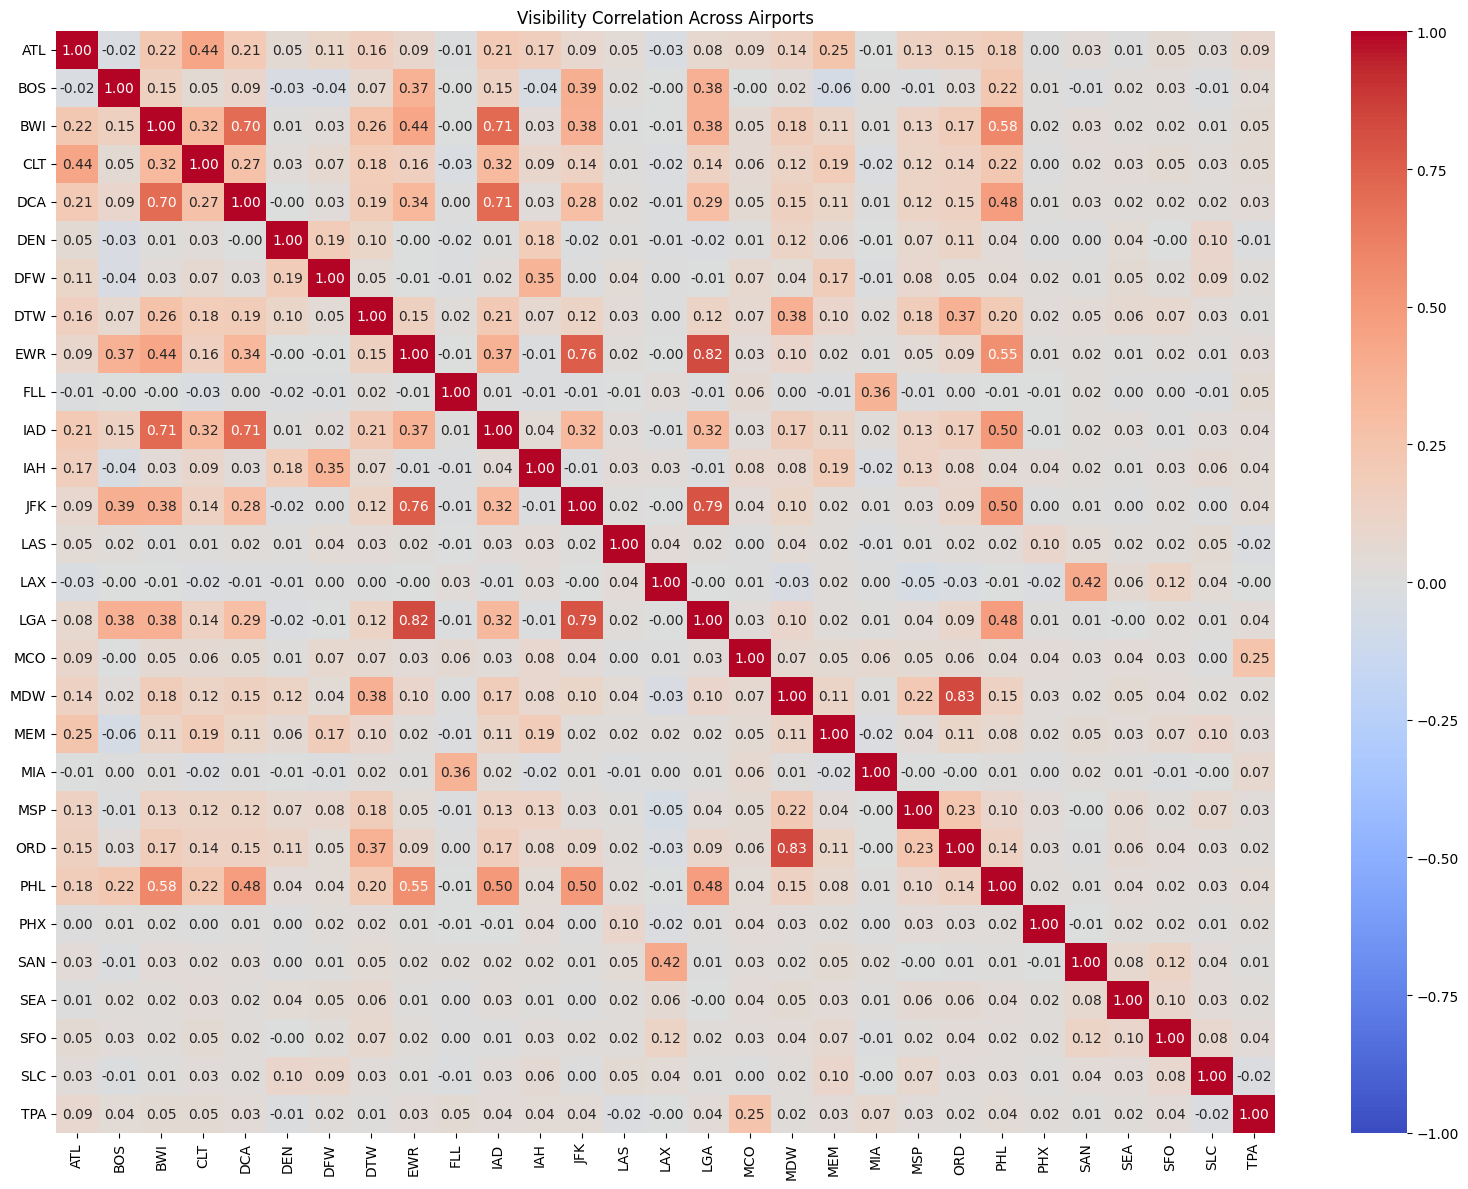

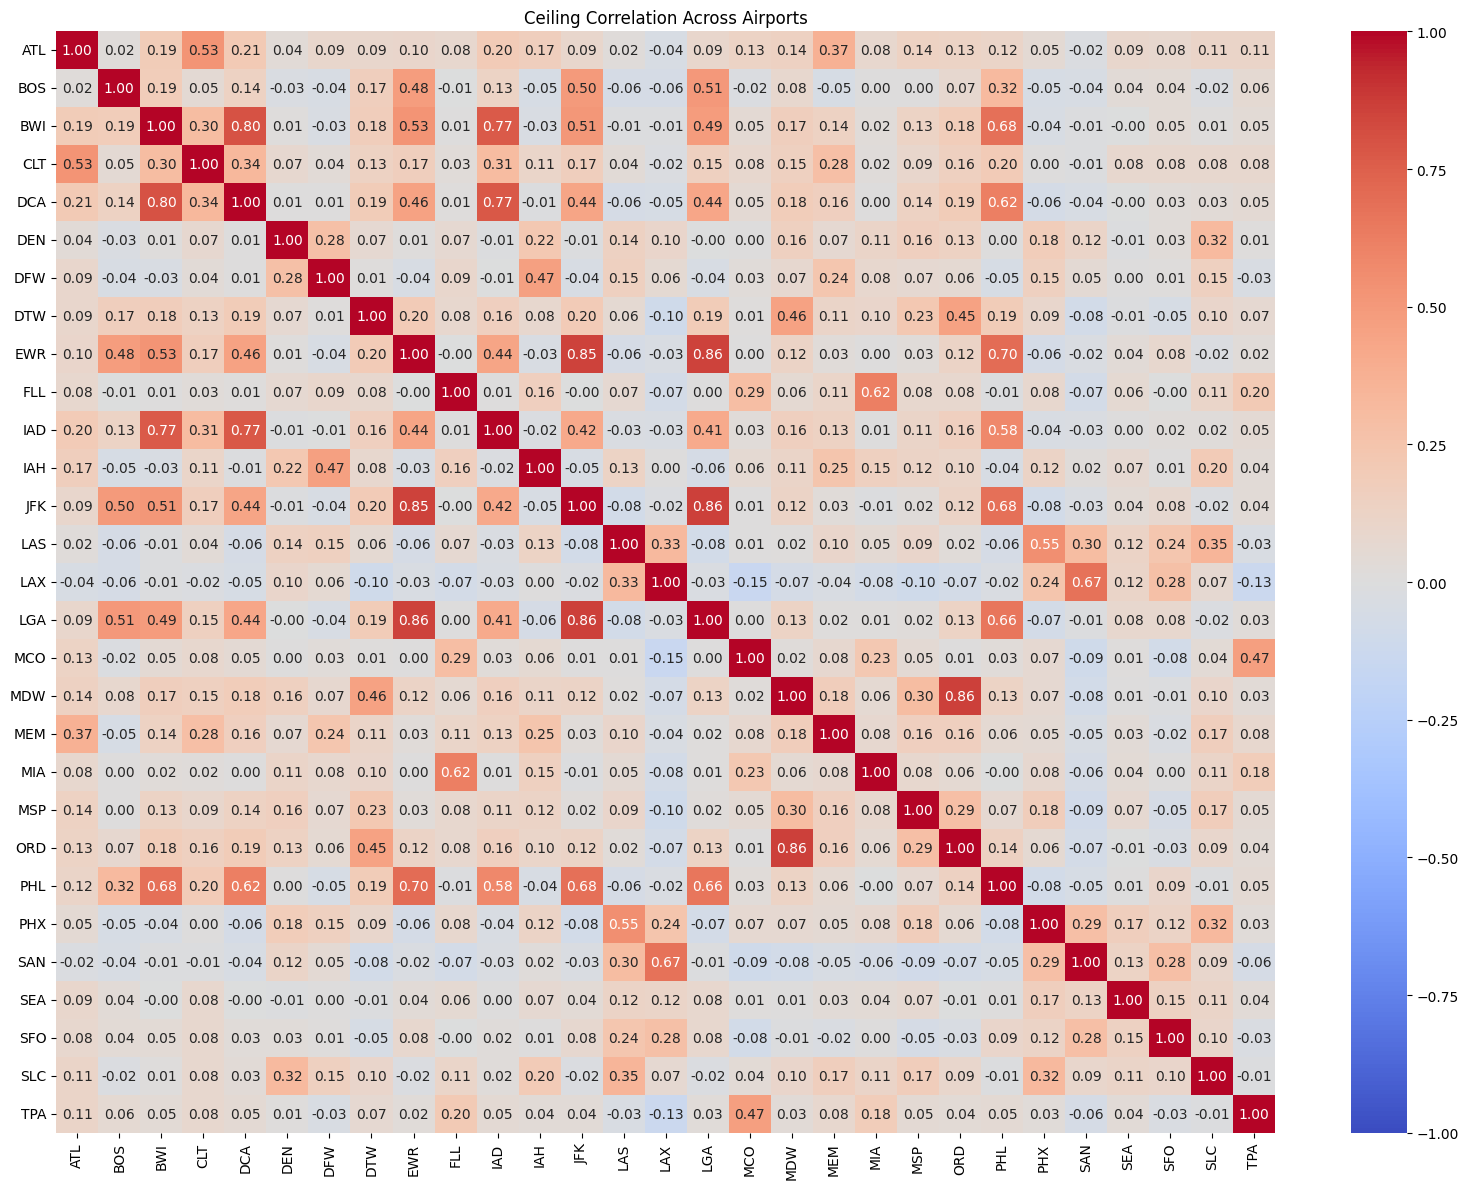

In [ ]:
# Visibility correlation analysis
vis_columns = [f'{code}_visibility' for code in airports]
df_vis = df_all.select(vis_columns)

pd_array_vis = df_vis.to_pandas()
corr_vis = pd_array_vis.corr()
corr_vis.index = [col[:3].upper() for col in corr_vis.index]
corr_vis.columns = [col[:3].upper() for col in corr_vis.columns]

plt.figure(figsize=(16, 12))
sns.heatmap(corr_vis, annot=True, xticklabels=True, yticklabels=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Visibility Correlation Across Airports")
plt.tight_layout()
plt.show()

# Ceiling correlation analysis
ceiling_columns = [f'{code}_ceiling' for code in airports]
df_ceiling = df_all.select(ceiling_columns)

pd_array_ceiling = df_ceiling.to_pandas()
corr_ceiling = pd_array_ceiling.corr()
corr_ceiling.index = [col[:3].upper() for col in corr_ceiling.index]
corr_ceiling.columns = [col[:3].upper() for col in corr_ceiling.columns]

plt.figure(figsize=(16, 12))
sns.heatmap(corr_ceiling, annot=True, xticklabels=True, yticklabels=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Ceiling Correlation Across Airports")
plt.tight_layout()
plt.show()

In [ ]:
# Delay correlation analysis
schedule_dfs = []

for code in airports:
    monthly_files = [
        f'../data/bts_remapped/{code}/2019/clean_daily/parquet/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2019_{month}_{code}.parquet'
        for month in range(1, 13)
    ]

    # Read all months for this airport and concatenate
    monthly_dfs = []
    for file in monthly_files:
        if os.path.exists(file):
            df = pl.read_parquet(file).select(
                pl.col('date'),
                pl.col('Flight_Number_Reporting_Airline').alias(f'{code}_flight_number'),
                pl.col('scheduled_departure_time').alias(f'{code}_scheduled_departure'),
                pl.col('scheduled_arrival_time').alias(f'{code}_scheduled_arrival'),
                pl.col('actual_departure_time').alias(f'{code}_actual_departure'),
                pl.col('actual_arrival_time').alias(f'{code}_actual_arrival'),
                pl.col('departure_delay').alias(f'{code}_departure_delay'),
                pl.col('arrival_delay').alias(f'{code}_arrival_delay'),
            )
            monthly_dfs.append(df)
        else:
            raise FileNotFoundError(f"Schedule file for {code} not found: {file}")

    if monthly_dfs:
        airport_df = pl.concat(monthly_dfs)
        schedule_dfs.append(airport_df)
    else:
        raise ValueError(f"No schedule data found for {code} in the specified months.")

In [77]:
# flight count is summed daily?
# capacity is hourly
# delays are averaged daily
agg_dfs = []

for df in schedule_dfs:
    code = df.columns[1][:3]  # Extract airport code from the first column name

    agg = df.group_by('date').agg(
        pl.col(f'{code}_flight_number').count().alias(f'{code}_flight_count'),
        pl.col(f'{code}_scheduled_departure').mean().alias(f'{code}_scheduled_departure'),
        pl.col(f'{code}_scheduled_arrival').mean().alias(f'{code}_scheduled_arrival'),
        pl.col(f'{code}_actual_departure').mean().alias(f'{code}_actual_departure'),
        pl.col(f'{code}_actual_arrival').mean().alias(f'{code}_actual_arrival'),
        pl.col(f'{code}_departure_delay').mean().alias(f'{code}_departure_delay'),
        pl.col(f'{code}_arrival_delay').mean().alias(f'{code}_arrival_delay'),
    )

    agg_dfs.append(agg)

In [79]:
agg_df_all = agg_dfs[0]

for df in agg_dfs[1:]:
    agg_df_all = agg_df_all.join(df, on='date')

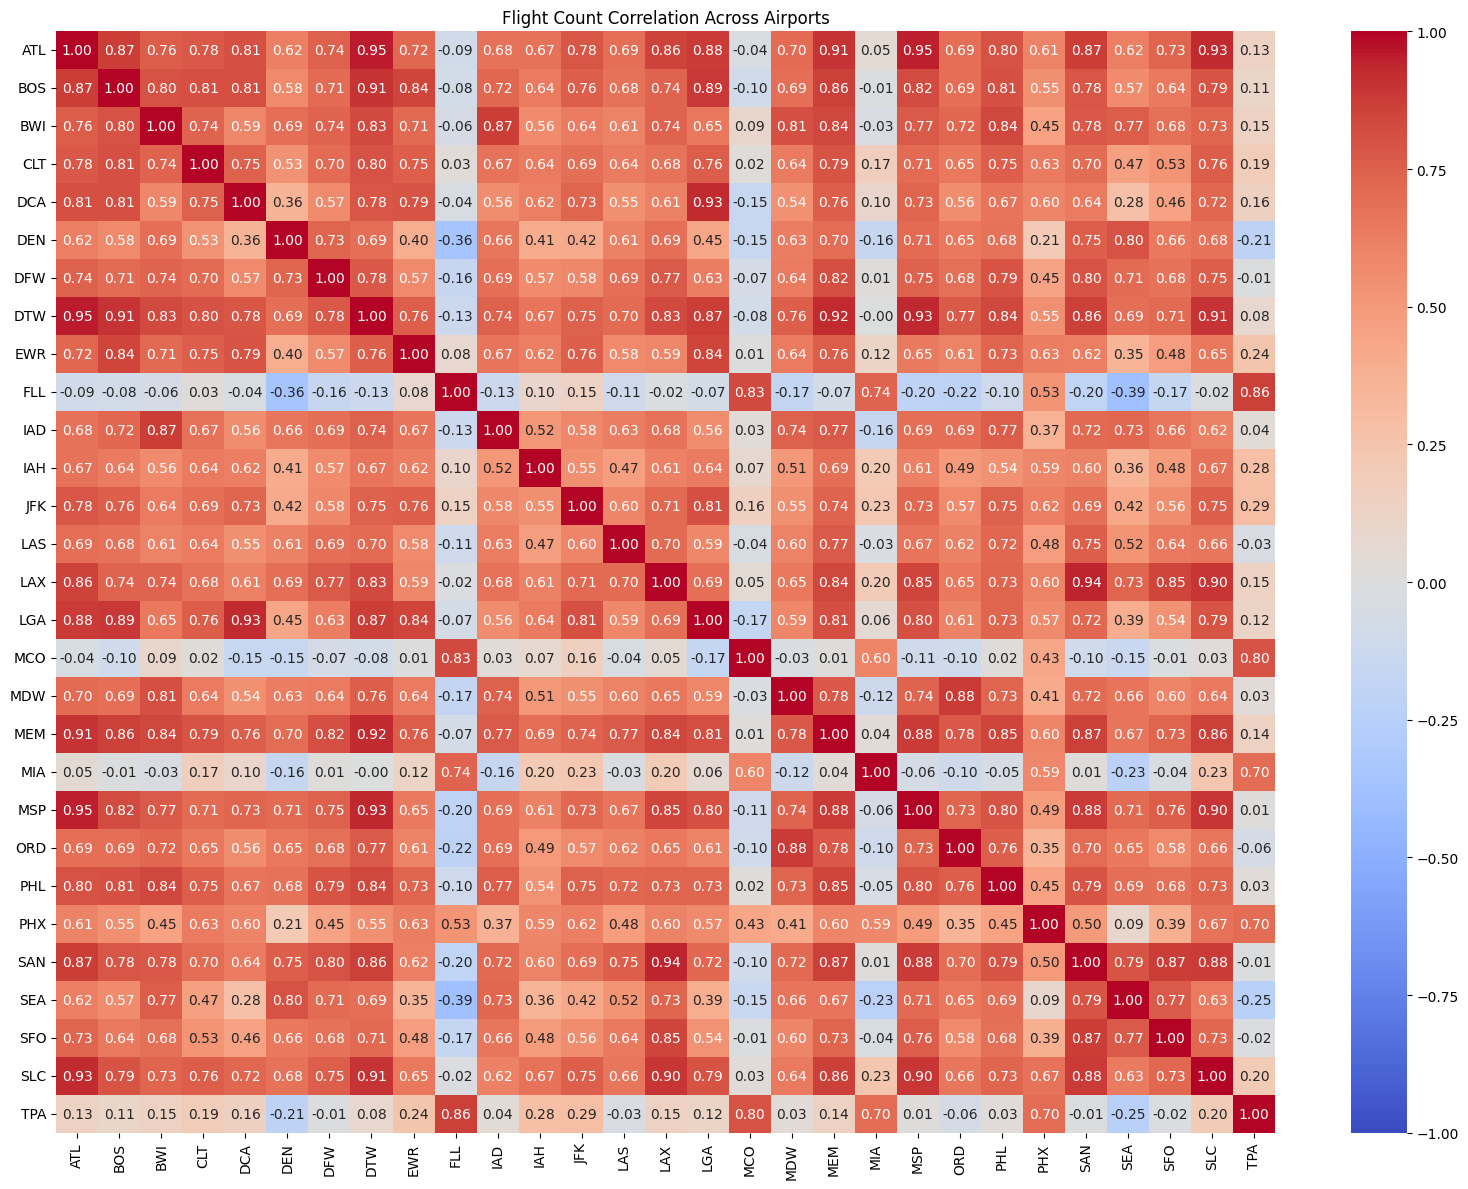

In [85]:
flight_count_columns = [f'{code}_flight_count' for code in airports]
df_flight_count = agg_df_all.select(flight_count_columns)

pd_array_flight_count = df_flight_count.to_pandas()
corr_flight_count = pd_array_flight_count.corr()
corr_flight_count.index = [col[:3].upper() for col in corr_flight_count.index]
corr_flight_count.columns = [col[:3].upper() for col in corr_flight_count.columns]

plt.figure(figsize=(16, 12))
sns.heatmap(corr_flight_count, annot=True, xticklabels=True, yticklabels=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Flight Count Correlation Across Airports")
plt.tight_layout()
plt.show()

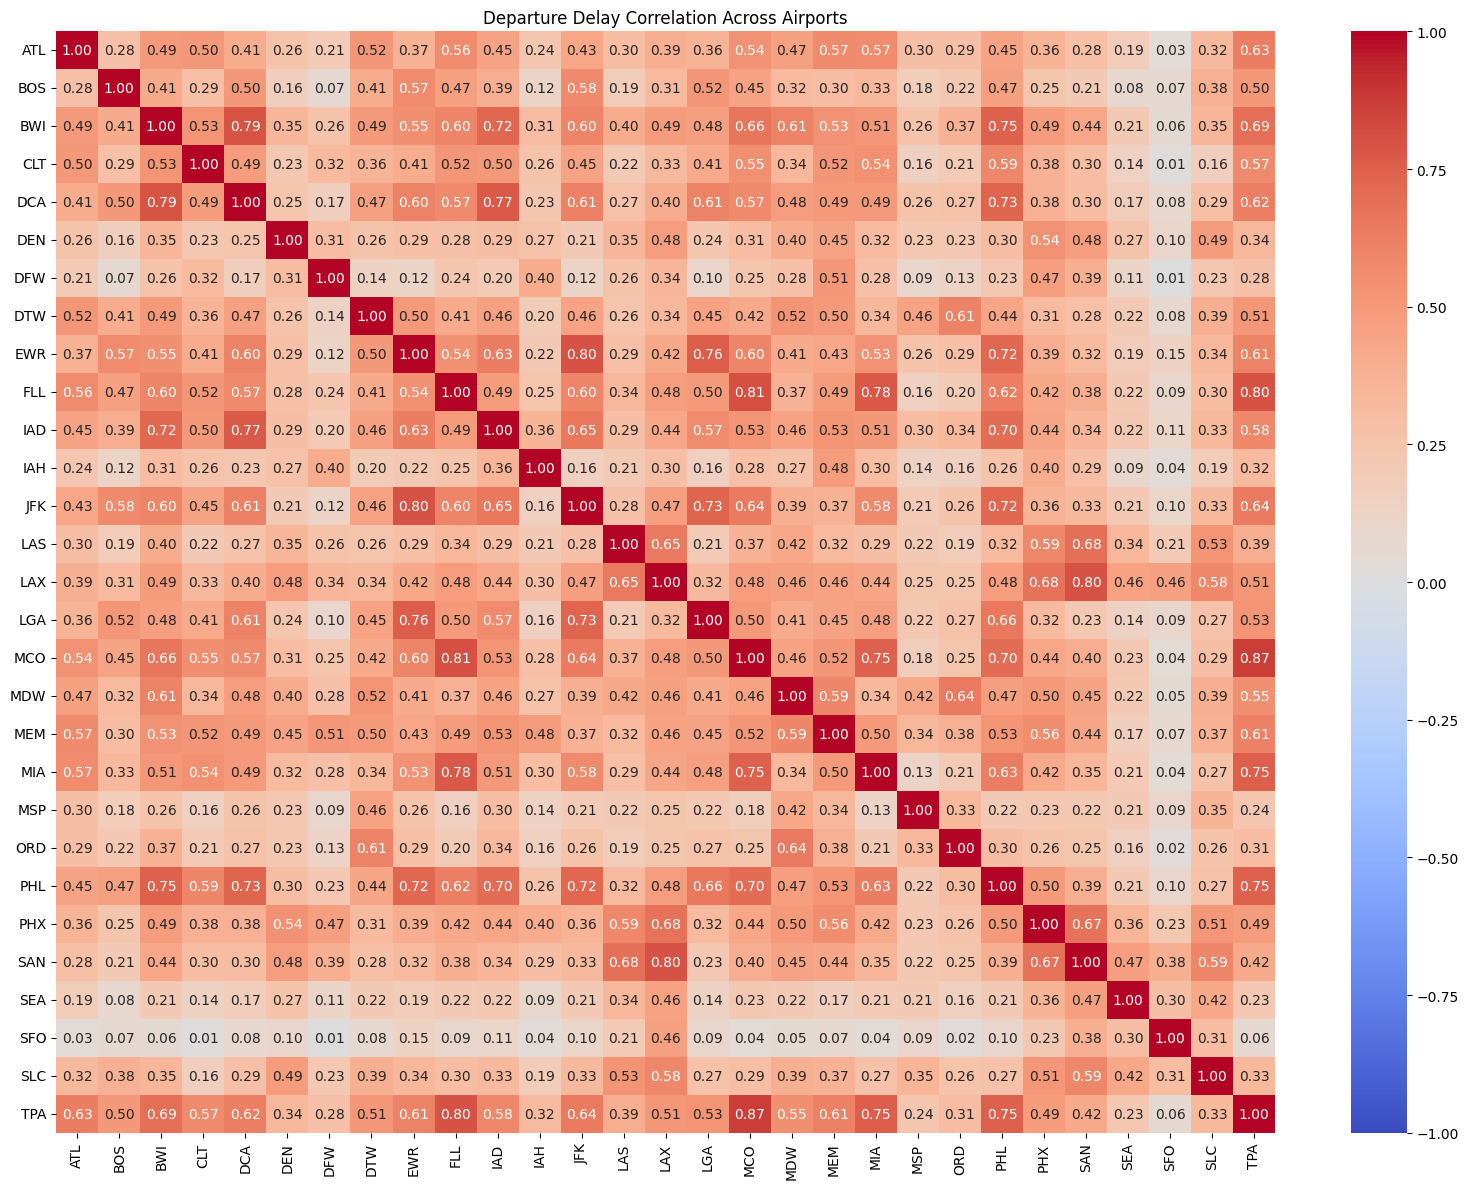

In [83]:
dep_delay_columns = [f'{code}_departure_delay' for code in airports]
df_dep_delay = agg_df_all.select(dep_delay_columns)

pd_array_dep_delay = df_dep_delay.to_pandas()
corr_dep_delay = pd_array_dep_delay.corr()
corr_dep_delay.index = [col[:3].upper() for col in corr_dep_delay.index]
corr_dep_delay.columns = [col[:3].upper() for col in corr_dep_delay.columns]

plt.figure(figsize=(16, 12))
sns.heatmap(corr_dep_delay, annot=True, xticklabels=True, yticklabels=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Departure Delay Correlation Across Airports")
plt.tight_layout()
plt.show()


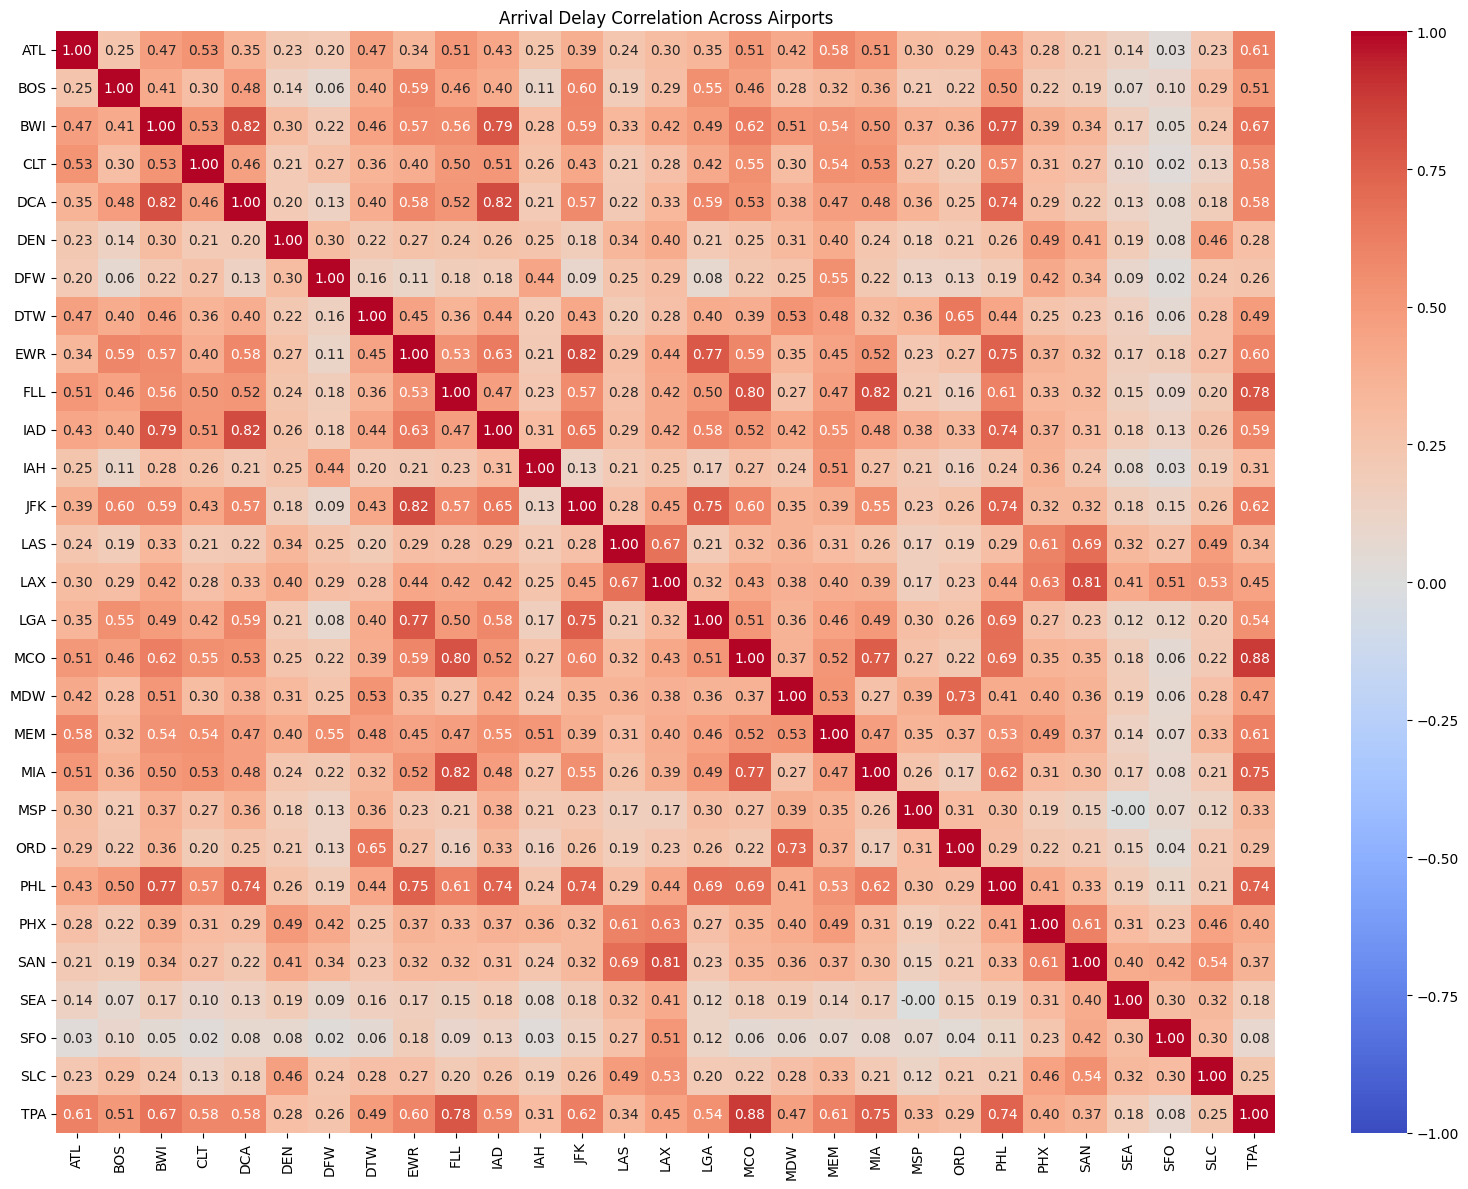

In [84]:
arr_delay_columns = [f'{code}_arrival_delay' for code in airports]
df_arr_delay = agg_df_all.select(arr_delay_columns)

pd_array_arr_delay = df_arr_delay.to_pandas()
corr_arr_delay = pd_array_arr_delay.corr()
corr_arr_delay.index = [col[:3].upper() for col in corr_arr_delay.index]
corr_arr_delay.columns = [col[:3].upper() for col in corr_arr_delay.columns]

plt.figure(figsize=(16, 12))
sns.heatmap(corr_arr_delay, annot=True, xticklabels=True, yticklabels=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Arrival Delay Correlation Across Airports")
plt.tight_layout()
plt.show()
